# Baseline model

In [33]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sktime.utils.plotting import plot_series, plot_lags, plot_correlations
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.split import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_error
from sklearn.metrics import accuracy_score
from math import sqrt

from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import pickle

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import DeterministicProcess
from xgboost import XGBRegressor

# hide warnings
warnings.filterwarnings("ignore")

In [2]:
# Set Matplotlib defaults
#print(plt.style.available)
#plt.style.use("seaborn-v0_8-whitegrid'")

plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)

plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

In [3]:
def make_lags(ts, lags):

    """Function to create lag features

    Returns:
        df: df with added lag features
    """
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

In [4]:
holidays_url = '../data//holidays_events.csv'
oil_url = '../data//oil.csv'
stores_url = '../data/stores.csv'
test_url = '../data/test.csv'
train_url = '../data//train.csv'
transactions_url = '../data/transactions.csv'

In [5]:
# Load Data to data frame
df_holidays = pd.read_csv(holidays_url)
df_oil = pd.read_csv(oil_url)
df_stores = pd.read_csv(stores_url)
df_test = pd.read_csv(test_url)
df_train = pd.read_csv(train_url)
df_transactions = pd.read_csv(transactions_url)

In [6]:
# Convert 'date' to datetime
df_holidays['date'] = pd.to_datetime(df_holidays['date'])
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])
df_transactions['date'] = pd.to_datetime(df_transactions['date']) 

In [7]:
# Filling missing oil prices
full_date_range = pd.date_range(start=df_oil['date'].min(), end=df_oil['date'].max())
full_date_df = pd.DataFrame({'date': full_date_range})
df_oil = pd.merge(full_date_df, df_oil, on='date', how='left')
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].interpolate(method='linear')

In [8]:
df_train.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [10]:
#date to datetime object

df_train['date'] = df_train.date.dt.to_period('D')
df_train = df_train.set_index(['date']).sort_index()

df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['date']).sort_index()


In [11]:
def create_dic_train(groups, lags):

    """Function to create dic for train set with separate data frames for stores and product families,
        including lag features

    Returns:
        dic_groups: dic of all the data frames
    """

    #create dic
    dic_groups = {}

    #feature engineering of data frames
    for (store, family), df in groups:

        #create lags 
        for i in lags:
            df[f'sales_lag_{i}'] = df['sales'].shift(i) 

        df = df.dropna()    #drop NaN values
        df.drop(columns= 'id', inplace= True) #drop id column

        #check if store already in dic
        if store not in dic_groups:
            dic_groups[store] = {}

        #store df in nested dic
        dic_groups[store][family] = df

        print(f'''
        Store-No.: {store}
        ---------------------------
        Product family: {family}
        ---------------------------''')  # Identifier (e.g., store and product)
        print(df)   # DataFrame for this particular store-product combination

    return dic_groups

##### -----------------------------------------#####------------------------------------------- #####

def create_dic_test(groups):

    """Function to create dic for test set with separate data frames for stores and product families

    Returns:
        dic_groups: dic of all the data frames
    """

    #create dic
    dic_groups = {}

    #feature engineering of data frames
    for (store, family), df in groups:

        #check if store already in dic
        if store not in dic_groups:
            dic_groups[store] = {}

        #store df in nested dic
        dic_groups[store][family] = df

        print(f'''
        Store-No.: {store}
        ---------------------------
        Product family: {family}
        ---------------------------''')  # Identifier (e.g., store and product)
        print(df)   # DataFrame for this particular store-product combination

    return dic_groups


In [14]:
#create group element
groups_train = df_train.groupby(['store_nbr','family'])
groups_test = df_test.groupby(['store_nbr','family'])

#set lags to create as list
lags = [1]

dic_group_train = create_dic_train(groups_train, lags)
dic_group_test = create_dic_test(groups_test)


        Store-No.: 1
        ---------------------------
        Product family: AUTOMOTIVE
        ---------------------------
            store_nbr      family  sales  onpromotion  sales_lag_1
date                                                              
2013-01-02          1  AUTOMOTIVE    2.0            0          0.0
2013-01-03          1  AUTOMOTIVE    3.0            0          2.0
2013-01-04          1  AUTOMOTIVE    3.0            0          3.0
2013-01-05          1  AUTOMOTIVE    5.0            0          3.0
2013-01-06          1  AUTOMOTIVE    2.0            0          5.0
...               ...         ...    ...          ...          ...
2017-08-11          1  AUTOMOTIVE    1.0            0          9.0
2017-08-12          1  AUTOMOTIVE    6.0            0          1.0
2017-08-13          1  AUTOMOTIVE    1.0            0          6.0
2017-08-14          1  AUTOMOTIVE    1.0            0          1.0
2017-08-15          1  AUTOMOTIVE    4.0            0          1.0


(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: ylabel='sales'>,
        <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

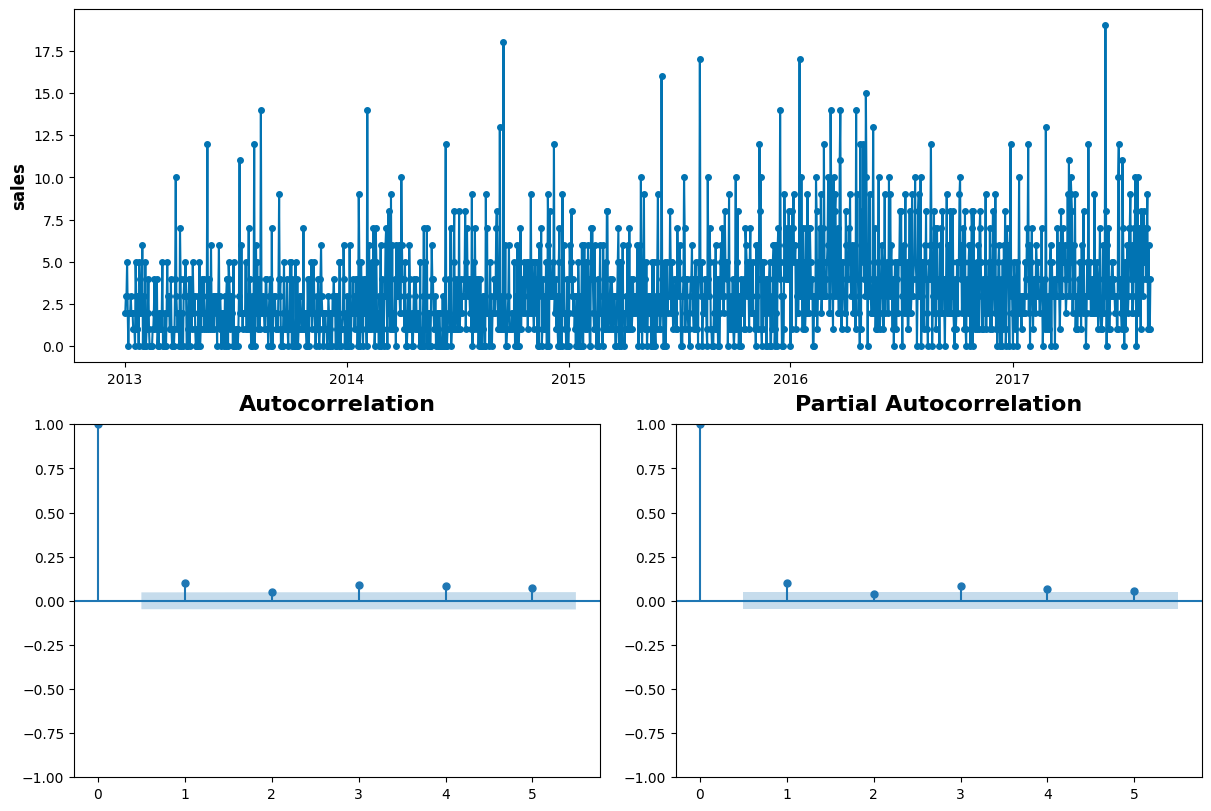

In [15]:
#plot autocorr and partial corr
plot_correlations(dic_group_train[1]['AUTOMOTIVE']['sales'], lags= 5)

In [16]:
#create list of all stores and families

stores = []
families = []

for store in dic_group_train.keys():
    stores.append(store)

for family in dic_group_train[stores[0]].keys():
    families.append(family)

In [17]:
dic_group_train[1]['AUTOMOTIVE']['sales'].to_frame()

sales
2013-01-02    2.0
2013-01-03    3.0
2013-01-04    3.0
2013-01-05    5.0
2013-01-06    2.0
...           ...
2017-08-11    1.0
2017-08-12    6.0
2017-08-13    1.0
2017-08-14    1.0
2017-08-15    4.0

[1683 rows x 1 columns]

In [18]:
dic_group_train[1]['AUTOMOTIVE']['sales'].to_frame()

sales
2013-01-02    2.0
2013-01-03    3.0
2013-01-04    3.0
2013-01-05    5.0
2013-01-06    2.0
...           ...
2017-08-11    1.0
2017-08-12    6.0
2017-08-13    1.0
2017-08-14    1.0
2017-08-15    4.0

[1683 rows x 1 columns]

In [37]:
#create baseline model with naive forecaster or exponential smoothing

def baseline_model(dic_group_train, forecaster, families = families, stores = stores):

    """function to create baseline model with naive forecaster or exponential smoothing,
        preprocessing, fitting, predicting, evaluation with MAE


    Returns:
        dic_pred: dic of y_train, y_val, y_pred_train, y_pred_val, mae_train, mae_val
        dff_error: df of all the mae values for the validation series 
    """

    dic_pred = {}
    df_error_train = pd.DataFrame(columns= families, index= stores)
    df_error_val = pd.DataFrame(columns= families, index= stores)


    for store in dic_group_train.keys():
        for family, df in dic_group_train[store].items():

            y = df['sales']

            y_train, y_val = temporal_train_test_split(y, test_size= 10)
            fh = ForecastingHorizon(y_val.index, is_relative=False)

            forecaster.fit(y_train)
            y_pred_val = forecaster.predict(fh)
            y_pred_train = forecaster.predict(y_train.index)

            #RMSLE (Root Mean Squared Logarithmic Error)
            #with scaling due to negative values in the prediction
            rmsle_train = sqrt(mean_squared_log_error(minmax_scale(y_train), minmax_scale(y_pred_train)))
            rmsle_val = sqrt(mean_squared_log_error(minmax_scale(y_val), minmax_scale(y_pred_val)))

            #check if store already in dic
            if store not in dic_pred:
                dic_pred[store] = {}

            #store df in nested dic
            dic_pred[store][family] = [y_train, y_val, y_pred_train, y_pred_val, rmsle_train, rmsle_val]

            #matrix of RMSLE
            df_error_train[f'{family}'][store] = rmsle_train
            df_error_val[f'{family}'][store] = rmsle_val

        
    return dic_pred, df_error_train, df_error_val
        

In [20]:
#plot results for store and family

def print_baseline_model(dic_pred, store, family, interval=50):

    """Function to plot MAE values for train and val series and graph 
        with true and predicted values
    """

    y_train, y_val, y_pred_train, y_pred_val, rmsle_train, rmsle_val = dic_pred[store][family]
    
    #print store and family
    # print(f'Store-no.:      {store}')
    # print(f'Product family: {family}')
    # print(10* '---')

    #print mae
    print(f'RMSLE for train: {round(rmsle_train,3)}')
    print(10* '---')
    print(f'RMSLE for val: {round(rmsle_val, 3)}')
    print(10* '---')

    # plotting for illustration
    plot_series(y_train[-interval:], y_pred_train[-interval:], y_val, y_pred_val, labels=["y_train", "y_pred_train", "y_val", "y_pred_val"])
    plt.title(f"Store-no.: {store} \n Product family: {family}")

In [38]:
#set forecaster
forecaster = NaiveForecaster(strategy="last")

#baseline model with naiv
dic_pred_naiv, df_error_train_naiv, df_error_val_naiv, df_accur_train_naiv, df_accur_val_naiv = baseline_model(dic_group_train, forecaster, families = families, stores = stores)

ValueError: not enough values to unpack (expected 5, got 3)

In [22]:
#set forecaster
forecaster = ExponentialSmoothing()

#baseline model with expo smoothing
dic_pred_exposmo, df_error_train_exposm, df_error_val_exposm, df_accur_train_exposm, df_accur_val_exposm = baseline_model(dic_group_train, forecaster, families = families, stores = stores)

In [23]:
df_error_train_exposm.head()

AUTOMOTIVE BABY CARE    BEAUTY BEVERAGES     BOOKS BREAD/BAKERY CELEBRATION   
1   0.253024       0.0  0.184217   0.14532  0.104032      0.19208    0.235039  \
2   0.288585  0.185155  0.293952  0.182278  0.053654     0.157114    0.105944   
3    0.26189  0.197373  0.255065  0.151655  0.066599     0.153842    0.202179   
4   0.228178  0.035684  0.204064  0.127482  0.061919     0.170133    0.068481   
5   0.226939  0.118912  0.166392  0.093279  0.090218     0.178248    0.203025   

   CLEANING     DAIRY      DELI  ... MAGAZINES     MEATS PERSONAL CARE   
1  0.137395  0.176845  0.185831  ...  0.218024  0.256786       0.17427  \
2  0.134734  0.239629  0.136367  ...  0.144753  0.200405      0.083662   
3  0.160286  0.172037  0.133604  ...  0.085361  0.179083      0.160107   
4  0.110988  0.188978  0.156164  ...  0.116254   0.14457      0.146305   
5  0.139316  0.175493   0.14641  ...  0.128592  0.134714       0.10474   

  PET SUPPLIES PLAYERS AND ELECTRONICS   POULTRY PREPARED FOODS   PRODUCE   
1     0.229025                0.237757  0.232545       0.211407  0.180884  \
2     0.162079                0.083961  0.173845       0.133104  0.112374   
3     0.166926                0.097649  0.183586       0.141278  0.109861   
4     0.213413                0.152956  0.191634       0.193569  0.126799   
5     0.203955                0.120034  0.101939       0.133975  0.066796   

  SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
1                   0.110168  0.238501  
2                   0.128194  0.169926  
3                   0.162919  0.126597  
4                   0.193106  0.160943  
5                    0.06121  0.194248  

[5 rows x 33 columns]

In [24]:
df_error_val_exposm.head()

AUTOMOTIVE BABY CARE    BEAUTY BEVERAGES BOOKS BREAD/BAKERY CELEBRATION   
1   0.422025       0.0  0.322317  0.509724   0.0     0.471878    0.401422  \
2   0.409657       0.0  0.442092  0.349142   0.0     0.393748    0.379022   
3   0.467442  0.309985  0.329731  0.280966   0.0      0.36792    0.267675   
4   0.396107  0.219192  0.293974  0.300791   0.0     0.340016    0.333338   
5   0.423972  0.269951  0.302047  0.389909   0.0     0.506291    0.402758   

   CLEANING     DAIRY      DELI  ... MAGAZINES     MEATS PERSONAL CARE   
1  0.499615  0.478112  0.479531  ...  0.314124  0.432744      0.434994  \
2  0.331217   0.35271  0.473049  ...  0.427955  0.313663      0.409804   
3  0.429964  0.360425  0.417131  ...  0.373424  0.293185      0.371903   
4  0.346473  0.351116  0.378516  ...  0.449038  0.347411      0.307345   
5  0.475713   0.40571  0.389778  ...  0.333069  0.393431      0.367331   

  PET SUPPLIES PLAYERS AND ELECTRONICS   POULTRY PREPARED FOODS   PRODUCE   
1     0.389093                0.339098  0.442117       0.409606  0.358468  \
2     0.412073                0.287113  0.367338       0.503297   0.40261   
3     0.406209                0.384258  0.451641        0.32568  0.418787   
4     0.325021                0.388195   0.41063       0.427999  0.411072   
5     0.490731                 0.51756  0.367261       0.358331   0.33686   

  SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
1                        0.0  0.279025  
2                        0.0  0.398922  
3                   0.347734  0.335182  
4                   0.219192  0.462515  
5                   0.284868  0.386139  

[5 rows x 33 columns]

RMSLE for train: 0.156
------------------------------
RMSLE for val: 0.422
------------------------------


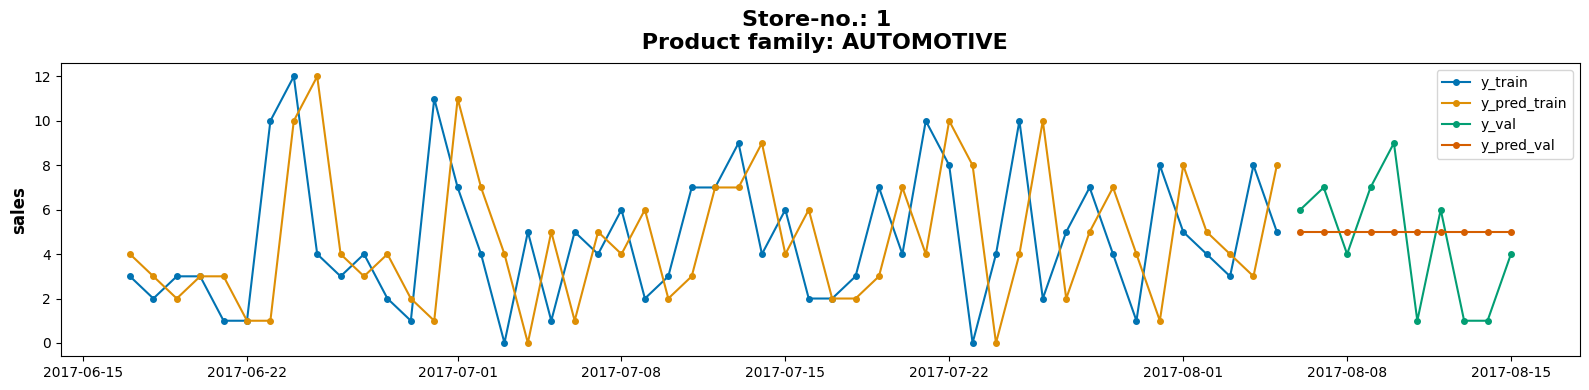

In [25]:
print_baseline_model(dic_pred_naiv, 1, 'AUTOMOTIVE', 50)

RMSLE for train: 0.253
------------------------------
RMSLE for val: 0.422
------------------------------


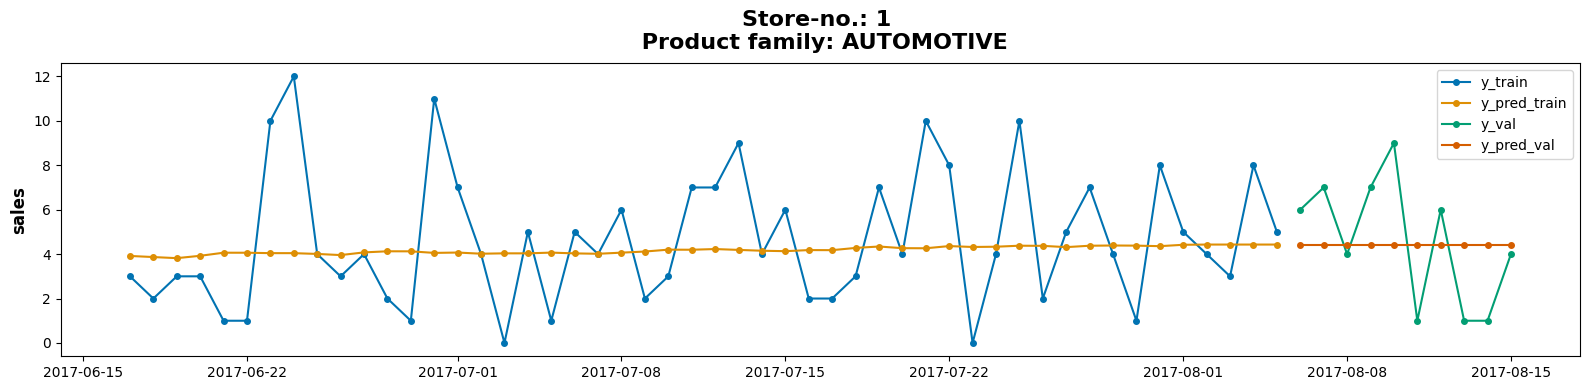

In [26]:
print_baseline_model(dic_pred_exposmo, 1, 'AUTOMOTIVE', 50)

In [53]:
def cum_rmsle(df_rmsle, axis):

    """Calculate mean values for error matrix by store, family or overall
    """

    if axis == 'store':
        print(f'RMSLE for all the stores: {round(df_rmsle.mean(axis= 1), 3)}')
    
    elif axis == 'family':
         print(f'RMSLE for all the product families: {round(df_rmsle.mean(axis= 0), 3)}')

    elif axis == 'all':
         print(f'RMSLE: {round(df_rmsle.values.mean(), 3)}')


print('Naive forecaster:')
print('------------------')
print('Train:')
cum_rmsle(df_error_train_naiv, 'all')
print('Validation:')
cum_rmsle(df_error_val_naiv, 'all')
print(10* '====')
print('Exponential smoothing:')
print('------------------')
print('Train:')
cum_rmsle(df_error_train_exposm, 'all')
print('Validation:')
cum_rmsle(df_error_val_exposm, 'all')

Naive forecaster:
------------------
Train:
RMSLE: 0.083
Validation:
RMSLE: 0.342
Exponential smoothing:
------------------
Train:
RMSLE: 0.156
Validation:
RMSLE: 0.342


In [54]:
def save_dic(dic, path, dic_name):

    """save dic as pickle
    """

    with open(f"{path}{dic_name}.pkl", "wb") as file:
        pickle.dump(dic, file)

In [29]:
#save dictionary of baseline model results
path = '../data/'
dic_name = 'dic_baseline_naiv_results'

save_dic(dic_pred_naiv, path, dic_name)


In [30]:
#save dictionary of baseline model results
path = '../data/'
dic_name = 'dic_baseline_exposmo_results'

save_dic(dic_pred_exposmo, path, dic_name)